# RNN - Sine Wave

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## What is a Sine Wave?
* Geometric waveform that oscilates up and down periodically.
* Defined by the function y = sin(x)


# Data

## What steps are needed for this part?
* Plotting the both x and y axis
* Creating a dataframe for both values
* Test / Train Split
* Normalize and Scale the data MinMaxScaler

In [84]:
x = np.linspace(0, 50, 501)

In [85]:
y = np.sin(x)

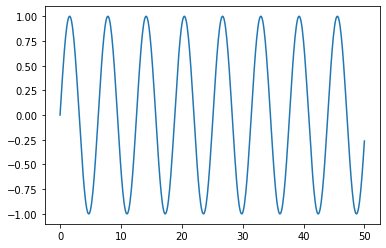

In [86]:
plt.plot(x, y)

In [87]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [88]:
test_percent = 0.1

In [89]:
test_point = np.round(len(df)*test_percent)
test_point

50.0

In [90]:
test_ind = int(len(df)-test_point)
test_ind

451

In [91]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [92]:
len(train)

451

In [93]:
len(test)

50

In [94]:
from sklearn.preprocessing import MinMaxScaler

In [95]:
scaler = MinMaxScaler()

In [96]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Batch Generator

## What is a batch in ML?
* Number of training examples utilized in one iteration

## TimeseriesGenerator(data, targets, length, batch_size)
This will return batches for a sequence data 
* data: We need to provide the x parameter
* targets: Source of the label
* length: Number of sequences
* batch_size: Number of timeseries samples in each batch

In [97]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [98]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [99]:
len(generator)

401

In [100]:
len(scaled_train)

451

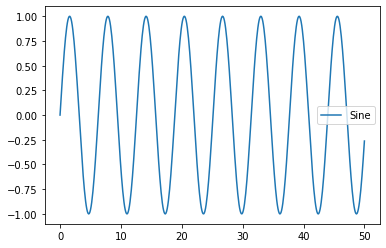

In [101]:
df.plot()

# Creating, training and evaluating the model

## SimpleRNN(units, input_shape)
This will return a simple rnn layer
* units = number of neurons, same as the length of the batches
* input_shape = We have to define an input shape, we can use the generator

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [103]:
n_features = 1

In [104]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(length, n_features)))

model.add(Dense(1))

#Loss must be mean squared error for continuous values
model.compile(optimizer='adam', loss='mse')

In [105]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit_generator(generator, epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


401/401 [==============================] - 3s 7ms/step - loss: 0.0113
Epoch 2/5
401/401 [==============================] - 3s 7ms/step - loss: 8.4356e-05
Epoch 3/5
401/401 [==============================] - 3s 7ms/step - loss: 3.9326e-04
Epoch 4/5
401/401 [==============================] - 3s 7ms/step - loss: 2.6948e-05
Epoch 5/5
401/401 [==============================] - 3s 6ms/step - loss: 9.1443e-05


In [107]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


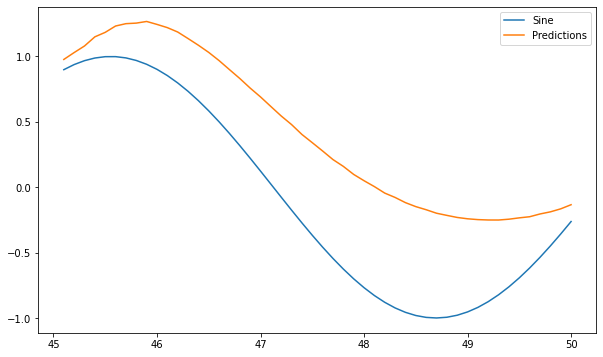

In [108]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(10, 6))

# LSTM

## What can we expect about this section?
We just saw the performance of our model, now let's compare it using LSTM

In [109]:
from tensorflow.keras.callbacks import EarlyStopping

In [110]:
# For RNN make patience more than 1, 2 is preferred
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [111]:
# We have to change the length of the generator both on test and train so we avoid errors
length = 49

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [112]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, n_features)))

model.add(Dense(1))

#Loss must be mean squared error for continuous values
model.compile(optimizer='adam', loss='mse')

In [113]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
402/402 [==============================] - 8s 16ms/step - loss: 0.0433 - val_loss: 1.5461e-05
Epoch 2/20
402/402 [==============================] - 6s 15ms/step - loss: 8.8431e-05 - val_loss: 1.4559e-05
Epoch 3/20
402/402 [==============================] - 6s 15ms/step - loss: 1.6181e-04 - val_loss: 3.3077e-05
Epoch 4/20
402/402 [==============================] - 6s 15ms/step - loss: 2.0669e-04 - val_loss: 9.1896e-06
Epoch 5/20
402/402 [==============================] - 6s 15ms/step - loss: 3.2713e-04 - val_loss: 9.6965e-05
Epoch 6/20
402/402 [==============================] - 6s 15ms/step - loss: 8.1587e-05 - val_loss: 2.1077e-05


In [114]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


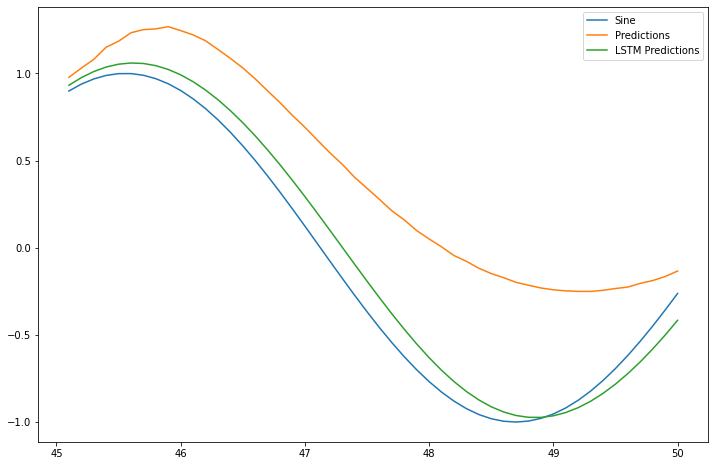

In [115]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12, 8))

# Forecast
Now we will forecast into the future:

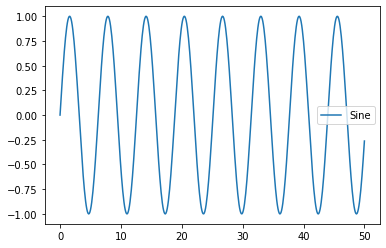

In [116]:
df.plot()

In [117]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

In [119]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [120]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [121]:
model.fit_generator(generator, epochs=6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
452/452 [==============================] - 9s 16ms/step - loss: 0.0965
Epoch 2/6
452/452 [==============================] - 7s 15ms/step - loss: 1.9057e-04
Epoch 3/6
452/452 [==============================] - 7s 15ms/step - loss: 1.3249e-04
Epoch 4/6
452/452 [==============================] - 7s 15ms/step - loss: 9.6578e-04
Epoch 5/6
452/452 [==============================] - 7s 15ms/step - loss: 1.2744e-04
Epoch 6/6
452/452 [==============================] - 7s 15ms/step - loss: 3.6254e-04


In [132]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(25):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [133]:
forecast = scaler.inverse_transform(forecast)

In [134]:
forecast_index = np.arange(50.1, 52.6, step=0.1)

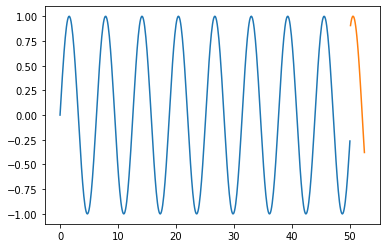

In [136]:
plt.plot(df.index, df['Sine'])
plt.plot(forecast_index, forecast)